In [1]:
import sys
from pathlib import Path
import functools

import mujoco
from brax import envs
import jax
import jax.numpy as jp

from envs import register_ahac_anymal
from shac.brax_wrappers import AppendObsHistory

import shac.networks as shac_networks
# import shac.train as  shac
from shac.train_class import SHAC

In [2]:
env_name = 'ahac_anymal'

log_sigma = None
make_networks_factory = functools.partial(
    shac_networks.make_shac_networks,
        policy_hidden_layer_sizes=(256, 128),
        value_hidden_layer_sizes =(256, 128),
        scalar_var=False,
        layer_norm=True)

In [3]:
# Debugging params
num_grad_checks = None
save_all_policy_gradients = True

# Training Parameters
num_epochs = 500
num_evals = num_epochs + 1
unroll_length = 8 # Somewhat learns at 1. Doesn't at 8. Blows up at 16.
num_envs = 64

num_timesteps = (num_envs*unroll_length)*num_epochs

num_critic_minibatches = 4
num_critic_data = num_envs*unroll_length
critic_batch_size = num_critic_data / num_critic_minibatches

episode_length = 1000

polgrad_thresh = 1e6

# Environment Parameters
env_kwargs = {
    "s_afilt_buf" : 1,
    "train_standing" : False,
    "termination_height" : 0.15,
    "phys_step" : 10,
    "model_variant" : "anymal"
}

h = 5 # The number of history steps.

In [4]:
# Warning: takes 40s
env      = AppendObsHistory(envs.get_environment(env_name, **env_kwargs), h=h)
eval_env = AppendObsHistory(envs.get_environment(env_name, **env_kwargs), h=h)
# env = envs.get_environment(env_name, **env_kwargs)
# eval_env = envs.get_environment(env_name, **env_kwargs)

In [5]:
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)


In [6]:
# state = jit_reset(jax.random.PRNGKey(0))
# state.obs
# state = jit_step(state, -1*jp.ones(1))
# state.obs
# state = jit_step(state, -1*jp.ones(1))
# state.obs

# state.obs.shape

In [7]:
# state.info['reward_tuple']

In [8]:
kwargs = dict( 
  num_timesteps=num_timesteps, log_sigma=log_sigma,
  num_evals=num_evals, use_tbx=True, tbx_logdir=f'{env_name}_log',
  tbx_experiment_name="obs_hist_unroll16", reward_scaling=1, 
  num_eval_envs = 64, num_envs=num_envs,
  unroll_length=unroll_length, critic_batch_size=critic_batch_size,
  critic_epochs = 16,target_critic_alpha = 0.2,
  discounting = 0.99, lambda_ = 0.95,
  normalize_observations=True,
  episode_length=episode_length, 
  network_factory = make_networks_factory, 
  seed=0, entropy_cost = 1e-3,
  resample_init=True,
  scramble_initial_times=True,
  num_grad_checks=num_grad_checks,
  save_all_checkpoints=True,
  polgrad_thresh=polgrad_thresh,
  save_all_policy_gradients=save_all_policy_gradients
  )

trainer = SHAC(environment=env, eval_env=eval_env, **kwargs)

Env steps per training step: 1024
Training steps per epoch: 1
Critic minibatches per critic epoch: 4
Initial eval time: 23.0827 s
Deleting old checkpoints!
Checkpointed for epoch 0


2024-03-06 09:55:09.335279: E external/xla/xla/service/gpu/buffer_comparator.cc:152] Difference at 1786970: -0.0601654, expected 0.0719863
2024-03-06 09:55:09.342308: E external/xla/xla/service/gpu/triton_autotuner.cc:804] Results do not match the reference. This is likely a bug/unexpected loss of precision.
2024-03-06 09:55:09.353984: E external/xla/xla/service/gpu/buffer_comparator.cc:152] Difference at 1786970: -0.0601654, expected 0.0719863
2024-03-06 09:55:09.361814: E external/xla/xla/service/gpu/triton_autotuner.cc:804] Results do not match the reference. This is likely a bug/unexpected loss of precision.
2024-03-06 09:55:09.374016: E external/xla/xla/service/gpu/buffer_comparator.cc:152] Difference at 1786970: -0.0601654, expected 0.0719863
2024-03-06 09:55:09.380863: E external/xla/xla/service/gpu/triton_autotuner.cc:804] Results do not match the reference. This is likely a bug/unexpected loss of precision.
2024-03-06 09:55:09.392582: E external/xla/xla/service/gpu/buffer_comp

XlaRuntimeError: INTERNAL: All algorithms tried for %dot.3760 = f32[64,294,256]{2,1,0} dot(f32[64,294,16]{1,0,2} %bitcast.150496, f32[64,16,256]{2,1,0} %parameter_3), lhs_batch_dims={0}, lhs_contracting_dims={2}, rhs_batch_dims={0}, rhs_contracting_dims={1}, metadata={op_name="jit(training_epoch)/jit(main)/while/body/jit(policy_gradient_update_fn)/vmap(transpose(jvp(MLP)))/hidden_0/transpose[permutation=(0, 2, 1)]" source_file="/home/andrew/Documents/thesis/jax_shac/shac/brax_networks.py" source_line=115} failed. Falling back to default algorithm.  Per-algorithm errors:
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.
  Results do not match the reference. This is likely a bug/unexpected loss of precision.

In [ ]:
make_inference_fn, policy_params, value_params, _= trainer.train()

#### Eval

In [ ]:
# utils_path = Path(Path.cwd().parent,
#                   Path("benchmarks"),
#                   Path("quadruped_stability_studies"))
# sys.path.append(str(utils_path))

from jax_shac.utils.eval_utils import plot_jacobian_norms, visualize_rollout, plot_rews

In [ ]:
renderer = mujoco.Renderer(env.model)

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(make_inference_fn(policy_params))

rng = jax.random.key(141)
init_key, rollout_key, rng = jax.random.split(rng, 3)
s0 = jit_reset(init_key)

jit_inference_fn = jax.jit(make_inference_fn(policy_params))

In [ ]:
if False:
    def spoof_policy(_, rng):
        bb = jax.random.choice(rng, jp.array([-1, 1]), 
                            p=jp.array([0.9, 1]))
        return bb.reshape(1), {}
        # return 2*(jax.random.uniform(rng).reshape(1)-0.5), {}
    jit_inference_fn = jax.jit(spoof_policy)

In [ ]:
if True:
    """ 
    Nan gradients:
    - Not seen in forward-mode AD
    - Jacrev doesn't work
    - Unclear whether nan's in training come from user code or MJX
        - https://github.com/google-deepmind/mujoco/issues/1349
    """
    all_jacs, state_jacs, ctrl_jacs = plot_jacobian_norms(s0, rollout_key, env, jit_inference_fn,
                                                jit_step, episode_length=240,
                                                ret_jacs=True, jacmode='fwd')

TypeError: cannot reshape array of shape (12,) (size 12) into shape 1 (size 1)

In [ ]:
state_h, states = visualize_rollout(s0, rollout_key, env, 
                                    jit_inference_fn, jit_step, renderer, 
                                    episode_length=240, print_nans=False, 
                                    print_dones=True, ret_states=True, camera="track")

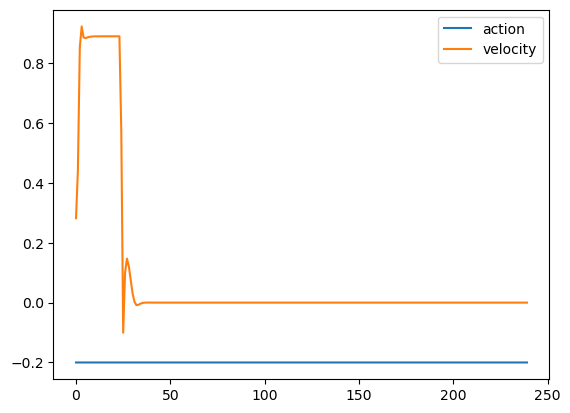

In [ ]:
rews = plot_rews(states)

## Debugging the Large Gradient Variance

#### Policy gradient sizes across enviroments

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jp
import pickle
import jax
import operator

it = None # TODO
# Load policy gradients
bgrad_path = f"/home/andrew/Documents/thesis/jax_shac/shac/policy_gradients/bgrad_{it}.pkl"
bgrad = pickle.load(open(bgrad_path, "rb"))

# Calculate the norm over the env axis for all leaves.
reduced_leaves = jax.tree_util.tree_map(lambda l: jp.linalg.norm(l, axis=(range(1, len(l.shape)))), bgrad)
pg_size_per_env = jax.tree.reduce(operator.add, reduced_leaves)

num_envs = 64
x_axis = jp.linspace(0, num_envs-1, num_envs)
plt.scatter(x_axis, pg_size_per_env)
plt.xlabel("Environment Number")
plt.ylabel("Policy gradient size")

#### Are large policy gradients caused by large mjx jacobians?

In [ ]:
# Repeat the offending unroll

algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, ts.normalizer_params,
                           state, key)
actions = extras["action"]
print(jacs.shape)

In [ ]:
jac_norms = jp.linalg.norm(jacs, axis=(2, 3))
assert len(jac_norms.shape) == 2
max_norm_per_env = jp.max(jac_norms, axis=1)

# Normalize both. 
assert len(pg_size_per_env) == 1
assert len(max_norm_per_env) == 1

n_pg_size_per_env = pg_size_per_env / jp.linalg.norm(pg_size_per_env)
n_max_norm_per_env = max_norm_per_env / jp.linalg.norm(max_norm_per_env)

plt.plot(n_pg_size_per_env, label="Policy gradient size")
plt.plot(n_max_norm_per_env, label="Size of max rollout mjx jacobian")
plt.legend()